In [ ]:
# mkdir data
# cd data
# wget https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip
# unzip vehicles.zip
# wget https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip
# unzip non-vehicles.zip
# https://github.com/udacity/self-driving-car/tree/master/annotations
# wget http://bit.ly/udacity-annotations-autti

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
import sklearn

from glob import glob
#from sklearn.cross_validation import train_test_split
from moviepy.editor import VideoFileClip
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from time import time

#np.set_printoptions(threshold=np.nan)
np.set_printoptions(threshold=10)

random.seed(0)

%matplotlib inline

In [2]:
PREFIX_PATH = '/Users/tringuyen/OneDrive/Documents/2017 - Udacity Self Driving Car course/CarND-Vehicle-Detection/'
# PREFIX_PATH = '/var/storage/shared/ipgsrch/trnguye/Google-Neural-Machine-Translation-GNMT-/tmp/CarND-Vehicle-Detection/'

PATH_TO_GTI_FAR_VEHICLES = \
    PREFIX_PATH + 'data/vehicles/GTI_Far/*.png'
PATH_TO_GTI_LEFT_VEHICLES = \
    PREFIX_PATH + 'data/vehicles/GTI_Left/*.png'
PATH_TO_GTI_CLOSE_VEHICLES = \
    PREFIX_PATH + 'data/vehicles/GTI_MiddleClose/*.png'
PATH_TO_GTI_RIGHT_VEHICLES = \
    PREFIX_PATH + 'data/vehicles/GTI_Right/*.png'
PATH_TO_KITTI_VEHICLES = \
    PREFIX_PATH + 'data/vehicles/KITTI*/*.png'
PATH_TO_GTI_NON_VEHICLES = \
    PREFIX_PATH + 'data/non-vehicles/GTI/*.png'
PATH_TO_KITTI_NON_VEHICLES = \
    PREFIX_PATH + 'data/non-vehicles/Extras/*.png'
    
PATH_TO_TEST_IMAGES = PREFIX_PATH + 'test_images/*.jpg'

PATH_TO_TEST_VIDEO_INTPUT = PREFIX_PATH + 'test_video.mp4'
PATH_TO_TEST_VIDEO_OUTPUT = PREFIX_PATH + 'test_video_out.mp4'

PATH_TO_PROJECT_VIDEO_INTPUT = PREFIX_PATH + 'project_video.mp4'
PATH_TO_PROJECT_VIDEO_OUTPUT = PREFIX_PATH + 'project_video_out.mp4'
PATH_TO_PROJECT_IMAGE_INTPUT_PREFIX = PREFIX_PATH + 'project_images/image_' 

In [3]:
MANUAL_SPLIT_VEHICLE_FILE_PATHS = [PATH_TO_GTI_FAR_VEHICLES, 
                                   PATH_TO_GTI_LEFT_VEHICLES, 
                                   PATH_TO_GTI_CLOSE_VEHICLES, 
                                   PATH_TO_GTI_RIGHT_VEHICLES]
RANDOM_SPLIT_VEHICLE_FILE_PATHS = [PATH_TO_KITTI_VEHICLES]
MANUAL_SPLIT_NON_VEHICLE_FILE_PATHS = [PATH_TO_GTI_NON_VEHICLES]
RANDOM_SPLIT_NON_VEHICLE_FILE_PATHS = [PATH_TO_KITTI_NON_VEHICLES]
TRAIN_DEV_TEST_SPLIT = (0.9, 0.05, 0.05)

In [4]:
def load_data(p_manual_split_file_paths, p_random_split_file_paths):
    output_train = []
    output_dev = []
    output_test = []

    if p_manual_split_file_paths is not None:
        for paths_to_file in p_manual_split_file_paths:
            paths_to_file = glob(paths_to_file)
            nb_files = len(paths_to_file)
            train, dev, test = \
                np.split(paths_to_file, 
                         [int(nb_files * TRAIN_DEV_TEST_SPLIT[0]), 
                          int(nb_files * (TRAIN_DEV_TEST_SPLIT[0] + TRAIN_DEV_TEST_SPLIT[1]))])
            output_train.append(train)
            output_dev.append(dev)
            output_test.append(test)
                
    for paths_to_file in p_random_split_file_paths:
        paths_to_file = glob(paths_to_file)
        train, dev_test = train_test_split(paths_to_file, train_size=TRAIN_DEV_TEST_SPLIT[0])
        dev, test = \
            train_test_split(
                dev_test,
                train_size=TRAIN_DEV_TEST_SPLIT[1] / (TRAIN_DEV_TEST_SPLIT[1] + TRAIN_DEV_TEST_SPLIT[2]))
        output_train.append(train)
        output_dev.append(dev)
        output_test.append(test)

    return np.concatenate(output_train), np.concatenate(output_dev), np.concatenate(output_test) 

In [5]:
def shuffle_image_paths(p_vehicle_image_file_paths, p_non_vehicle_image_file_paths):
    image_paths = np.concatenate((p_vehicle_image_file_paths, p_non_vehicle_image_file_paths))
    labels = np.concatenate((np.ones(len(p_vehicle_image_file_paths)), 
                             np.zeros(len(p_non_vehicle_image_file_paths))))
    image_paths, labels = shuffle(image_paths, labels)
    
    return image_paths, labels

In [6]:
def extract_features_from_single_image(
        p_image, 
        p_color_space='YCrCb', 
        p_resize=(64, 64),
        p_color_histogram_bin=32,
        p_color_histogram_bin_range=(0, 256),
        p_hog_orient=9, 
        p_hog_pix_per_cell=8, 
        p_hog_cell_per_block=4,
        #p_feature_types=['bin spacial', 'histogram', 'hog'],
        p_feature_types=['hog']):

    if p_color_space == 'HSV':
        image = cv2.cvtColor(p_image, cv2.COLOR_BGR2HSV)
    elif p_color_space == 'LUV':
        image = cv2.cvtColor(p_image, cv2.COLOR_BGR2LUV)
    elif p_color_space == 'HLS':
        image = cv2.cvtColor(p_image, cv2.COLOR_BGR2HLS)
    elif p_color_space == 'YUV':
        image = cv2.cvtColor(p_image, cv2.COLOR_BGR2YUV)
    elif p_color_space == 'YCrCb':
        image = cv2.cvtColor(p_image, cv2.COLOR_BGR2YCrCb)     

    image = cv2.resize(image, p_resize)
        
    features = np.array([])
    if 'bin spacial' in p_feature_types:
        bin_spatial_features = image.ravel()
        features = np.concatenate((features, bin_spatial_features))
    
    if 'histogram' in p_feature_types:
        color_histograms = []
        for channel in range(image.shape[2]):
            color_histograms.append(np.histogram(image[:, :, channel], 
                                                 bins=p_color_histogram_bin, 
                                                 range=p_color_histogram_bin_range)[0])
        features = np.concatenate((features, np.ravel(color_histograms)))

    if 'hog' in p_feature_types:
        hog_features = []
        for channel in range(image.shape[2]):
            hog_features.append(
                hog(image[:, :, channel],
                    orientations=p_hog_orient,
                    pixels_per_cell=(p_hog_pix_per_cell, p_hog_pix_per_cell),
                    cells_per_block=(p_hog_cell_per_block, p_hog_cell_per_block),
                    transform_sqrt=True,
                    visualise=False))
        features = np.concatenate((features, np.ravel(hog_features)))

    return features

In [7]:
def extract_features_from_file_paths(p_image_file_paths, p_labels):
    features = []
    #features_half_1 = []
    #features_half_2 = []
    
    features_flip = []
    #features_flip_half_1 = []
    #features_flip_half_2 = []
    
    for image_file_path in p_image_file_paths:
        image = cv2.imread(image_file_path)
        features.append(extract_features_from_single_image(image))
        
        #image_half_1, image_half_2 = np.hsplit(image, 2)
        #features_half_1.append(extract_features_from_single_image(image_half_1))
        #features_half_2.append(extract_features_from_single_image(image_half_2))
        
        image_flip = np.fliplr(image)
        features_flip.append(extract_features_from_single_image(image_flip))
        
        #image_flip_half_1, image_flip_half_2 = np.hsplit(image_flip, 2)
        #features_flip_half_1.append(extract_features_from_single_image(image_flip_half_1))
        #features_flip_half_2.append(extract_features_from_single_image(image_flip_half_2))

    #features.extend(features_half_1)
    #features.extend(features_half_2)
    features.extend(features_flip)
    #features.extend(features_flip_half_1)
    #features.extend(features_flip_half_2)
    features = np.vstack(features)
    
    labels = np.concatenate((p_labels, p_labels))
    
    return features, labels

In [8]:
train_scaled_features = None
train_labels = None
dev_scaled_features = None
dev_labels = None
test_scaled_features = None
test_labels = None

In [9]:
def train_classifier(p_verbal=True):
    global train_scaled_features
    global train_labels
    global dev_scaled_features
    global dev_labels
    global test_scaled_features
    global test_labels
    
    if train_scaled_features == None or \
       train_labels == None or \
       dev_scaled_features == None or \
       dev_labels == None or \
       test_scaled_features == None or \
       test_labels == None:

        if p_verbal:
            start_time = time()

        train_vehicles_file_paths, dev_vehicles_file_paths, test_vehicles_file_paths = \
            load_data(p_manual_split_file_paths=MANUAL_SPLIT_VEHICLE_FILE_PATHS, 
                      p_random_split_file_paths=RANDOM_SPLIT_VEHICLE_FILE_PATHS)
        train_non_vehicles_file_paths, dev_non_vehicles_file_paths, test_non_vehicles_file_paths = \
            load_data(p_manual_split_file_paths=MANUAL_SPLIT_NON_VEHICLE_FILE_PATHS, 
                      p_random_split_file_paths=RANDOM_SPLIT_NON_VEHICLE_FILE_PATHS)

        train_image_file_paths, train_labels = \
            shuffle_image_paths(train_vehicles_file_paths, train_non_vehicles_file_paths)
        dev_image_file_paths, dev_labels = \
            shuffle_image_paths(dev_vehicles_file_paths, dev_non_vehicles_file_paths)
        test_image_file_paths, test_labels = \
            shuffle_image_paths(test_vehicles_file_paths, test_non_vehicles_file_paths)

        train_features, train_labels = extract_features_from_file_paths(train_image_file_paths, train_labels)
        dev_features, dev_labels = extract_features_from_file_paths(dev_image_file_paths, dev_labels)
        test_features, test_labels = extract_features_from_file_paths(test_image_file_paths, test_labels)

        all_features = np.concatenate((train_features, dev_features, test_features)).astype(np.float64)                        
        feature_scaler = StandardScaler().fit(all_features)
        train_scaled_features = feature_scaler.transform(train_features)
        dev_scaled_features = feature_scaler.transform(dev_features)
        test_scaled_features = feature_scaler.transform(test_features)
        if p_verbal:
            print('Extract features in %.2f minutes' % ((time() - start_time) / 60.0))
    
    if p_verbal:
        start_time = time()
    # classifier = SVC()
    classifier = LinearSVC()
    # n_estimators = 10
    # classifier = BaggingClassifier(SVC(), max_samples=1.0 / n_estimators, n_estimators=n_estimators))

    # classifier = RandomForestClassifier(min_samples_leaf=20)
    classifier.fit(train_scaled_features, train_labels)
    if p_verbal:
        print('Train classifier in %.2f minutes' % ((time() - start_time) / 60.0))

    if p_verbal:
        start_time = time()
        train_accuracy = classifier.score(train_scaled_features, train_labels)
        print()
        print('Train accuracy: %f' % train_accuracy)
        print('Evaluate train accuracy in %d seconds' % (time() - start_time))

        start_time = time()
        dev_accuracy = classifier.score(dev_scaled_features, dev_labels)
        print()
        print('Dev accuracy: %f' % dev_accuracy)
        print('Evaluate dev accuracy in %d seconds' % (time() - start_time))

        start_time = time()
        test_accuracy = classifier.score(test_scaled_features, test_labels)
        print()
        print('Test accuracy: %f' % test_accuracy)
        print('Evaluate test accuracy in %d seconds' % (time() - start_time))
        
        print()
        print('Sample predictions:')
        for i in range(10):
            random_num = random.randint(1, 10)
            image_file_path = test_image_file_paths[random_num]
            features = test_scaled_features[random_num].reshape(1, -1)
            label = test_labels[random_num]
            plt.figure()
            plt.imshow(cv2.imread(image_file_path)[:,:,::-1])
            plt.title('Label: %d ; Predict: %d' % (label, classifier.predict(features)))      
    
    return feature_scaler, classifier

Extract features in 5.73 minutes
Train classifier in 4.36 minutes

Train accuracy: 1.000000
Evaluate train accuracy in 20 seconds

Dev accuracy: 0.993799
Evaluate dev accuracy in 1 seconds

Test accuracy: 0.972503
Evaluate test accuracy in 1 seconds

Sample predictions:


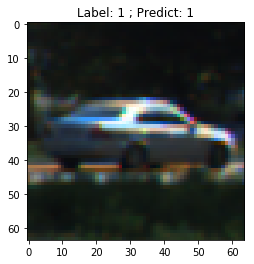

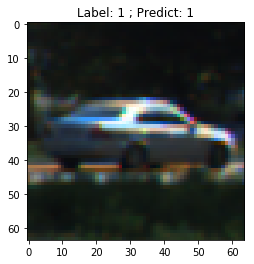

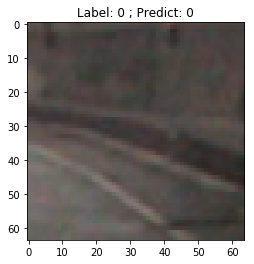

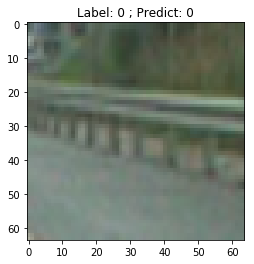

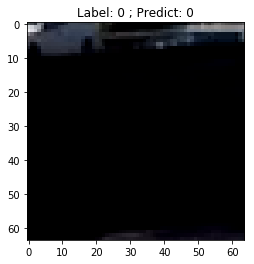

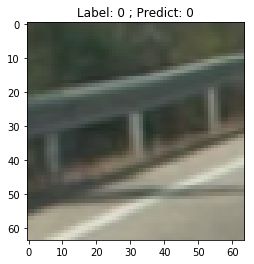

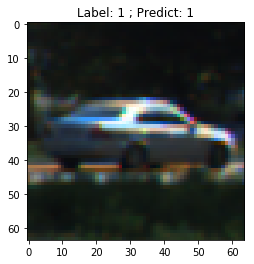

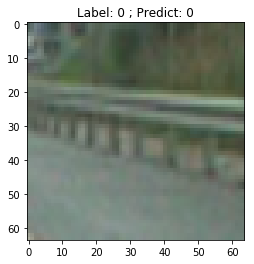

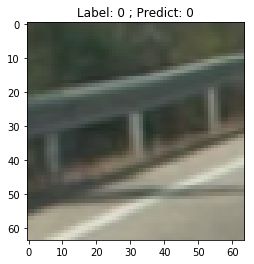

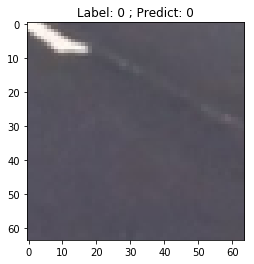

In [10]:
feature_scaler, classifier = train_classifier(p_verbal=True)

In [11]:
def create_single_heat_map(
        p_image, 
        p_row_span,
        p_col_span,
        p_feature_scaler,
        p_classifier,
        p_image_window_size=(64, 64),
        p_classifier_color_space='YCrCb',
        p_classifier_resize=(64, 64),
        p_classifier_color_histogram_bin=32,
        p_classifier_color_histogram_bin_range=(0, 256),
        p_classifier_hog_orient=9, 
        p_classifier_hog_pix_per_cell=8, 
        p_classifier_hog_cell_per_block=4,
        #p_classifier_feature_types=['bin spacial', 'histogram', 'hog'],
        p_classifier_feature_types=['hog']):
    
    heatmap = np.zeros((p_image.shape[0], p_image.shape[1]))

    search_area = p_image[p_row_span[0] : p_row_span[1], p_col_span[0] : p_col_span[1], :]
    
    if p_classifier_color_space == 'HSV':
        search_area = cv2.cvtColor(search_area, cv2.COLOR_BGR2HSV)
    elif p_classifier_color_space == 'LUV':
        search_area = cv2.cvtColor(search_area, cv2.COLOR_BGR2LUV)
    elif p_classifier_color_space == 'HLS':
        search_area = cv2.cvtColor(search_area, cv2.COLOR_BGR2HLS)
    elif p_classifier_color_space == 'YUV':
        search_area = cv2.cvtColor(search_area, cv2.COLOR_BGR2YUV)
    elif p_classifier_color_space == 'YCrCb':
        search_area = cv2.cvtColor(search_area, cv2.COLOR_BGR2YCrCb) 
        
    row_scaler = p_image_window_size[0] / p_classifier_resize[0] 
    col_scaler = p_image_window_size[1] / p_classifier_resize[1]
    search_area = cv2.resize(search_area, 
                             (np.int(search_area.shape[1] / col_scaler), 
                              np.int(search_area.shape[0] / row_scaler)))

    n_row_blocks = (search_area.shape[0] // p_classifier_hog_pix_per_cell) - p_classifier_hog_cell_per_block + 1
    n_col_blocks = (search_area.shape[1] // p_classifier_hog_pix_per_cell) - p_classifier_hog_cell_per_block + 1

    n_row_blocks_per_window = \
        (p_classifier_resize[0] // p_classifier_hog_pix_per_cell) - p_classifier_hog_cell_per_block + 1
    n_col_blocks_per_window = \
        (p_classifier_resize[1] // p_classifier_hog_pix_per_cell) - p_classifier_hog_cell_per_block + 1

    cells_per_step = p_classifier_hog_cell_per_block // 4

    n_row_block_steps = (n_row_blocks - n_row_blocks_per_window) // cells_per_step
    n_col_block_steps = (n_col_blocks - n_col_blocks_per_window) // cells_per_step

    if 'hog' in p_classifier_feature_types:
        hog_image_features = []
        for channel in range(search_area.shape[2]):
            hog_image_features.append(
                hog(search_area[:, :, channel],
                    orientations=p_classifier_hog_orient,
                    pixels_per_cell=(p_classifier_hog_pix_per_cell, p_classifier_hog_pix_per_cell),
                    cells_per_block=(p_classifier_hog_cell_per_block, p_classifier_hog_cell_per_block),
                    transform_sqrt=True,
                    visualise=False,
                    feature_vector=False))

    for row_block_step in range(n_row_block_steps):
        for col_block_step in range(n_col_block_steps):

            row_block = row_block_step * cells_per_step
            col_block = col_block_step * cells_per_step

            row_top = row_block * p_classifier_hog_pix_per_cell
            col_left = col_block * p_classifier_hog_pix_per_cell

            features = np.array([])
            if 'bin spacial' in p_classifier_feature_types:
                window_image = search_area[row_top : row_top + p_classifier_resize[0], 
                                           col_left : col_left + p_classifier_resize[1]]

                bin_spatial_features = window_image.ravel()
                features = np.concatenate((features, bin_spatial_features))
            
            if 'histogram' in p_classifier_feature_types:
                color_histograms = []
                for channel in range(window_image.shape[2]):
                    color_histograms.append(np.histogram(window_image[:, :, channel], 
                                                         bins=p_classifier_color_histogram_bin, 
                                                         range=p_classifier_color_histogram_bin_range)[0])
                color_histograms = np.ravel(color_histograms)
                features = np.concatenate((features, color_histograms))
            
            if 'hog' in p_classifier_feature_types:
                hog_window_features = []
                for channel in range(search_area.shape[2]):
                    hog_window_features.append(
                        hog_image_features[channel][
                            row_block : row_block + n_row_blocks_per_window, 
                            col_block : col_block + n_col_blocks_per_window])
                       
                hog_window_features = np.ravel(hog_window_features)

                features = np.concatenate((features, hog_window_features))
            
            features = features.reshape(1, -1)
            features = p_feature_scaler.transform(features)
                       
            prediction = p_classifier.predict(features)
            if prediction == 1:
                heatmap[p_row_span[0] + int(row_top * row_scaler) : 
                            p_row_span[0] + int((row_top + p_classifier_resize[0]) * row_scaler), 
                        p_col_span[0] + int(col_left * col_scaler) : 
                            p_col_span[0] + int((col_left + p_classifier_resize[1]) * col_scaler)] += 1
     
    
    return heatmap

In [12]:
def create_aggregated_heat_map(
        p_image,
        p_feature_scaler,
        p_classifier,
        p_blur,
        p_windows,
        p_verbose=True):
    
    heatmaps = []
    
    for window_size, window_row_span, window_column_span in p_windows:
        heatmap = create_single_heat_map(
            p_image=p_image,
            p_row_span=window_row_span,
            p_col_span=window_column_span,
            p_feature_scaler=p_feature_scaler,
            p_classifier=p_classifier,
            p_image_window_size=window_size)
        
        #heatmap[:, p_col_span[1] - image_window_size[1] : p_col_span[1]] = \
        #    heatmap[:, p_col_span[1] - 2 * image_window_size[1] : p_col_span[1] - image_window_size[1]] + \
        #    heatmap[:, p_col_span[1] - image_window_size[1] : p_col_span[1]]
        
        #heatmap[:, p_col_span[1] - int(image_window_size[1] / 2) : p_col_span[1]] = \
        #    heatmap[:, p_col_span[1] - int(image_window_size[1]) : 
        #               p_col_span[1] - int(image_window_size[1] / 2)] * 0.5 + \
        #    heatmap[:, p_col_span[1] - int(image_window_size[1] / 2) : p_col_span[1]] * 1.5

        heatmaps.append(heatmap)
    
    heatmaps = np.sum(heatmaps, axis=0)
    
    heatmaps = cv2.GaussianBlur(heatmaps, p_blur, 0)
    heatmaps = cv2.GaussianBlur(heatmaps, p_blur, 0)

    if p_verbose:
        plt.figure()
        plt.imshow(p_image[:,:,::-1])

        plt.figure()
        plt.imshow(heatmaps, cmap='hot', interpolation='nearest')
    
    return heatmaps

In [13]:
def draw_boxes(p_image, p_heatmap, p_threshold, p_verbose=True):
    threshold, thresholded_image = cv2.threshold(
        p_heatmap.astype(np.uint8), thresh=p_threshold, maxval=1, type=cv2.THRESH_BINARY)
    
    im3, contours, hierarchy = cv2.findContours(thresholded_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_L1)

    for i in range(0, len(contours)):
       contour = contours[i]
       x, y, w, h = cv2.boundingRect(contour)
       cv2.rectangle(p_image, (x, y), (x + w, y + h), (0, 0, 255), 10)
    
    if p_verbose:
        plt.figure()
        plt.imshow(p_image[:, :, : : -1])
    
    return p_image, thresholded_image

Finish processing image in 0.013 minutes


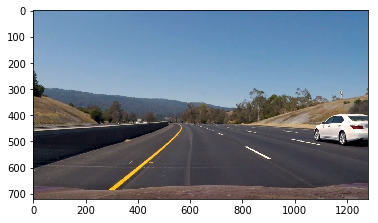

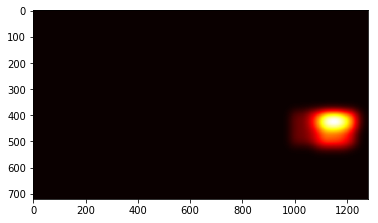

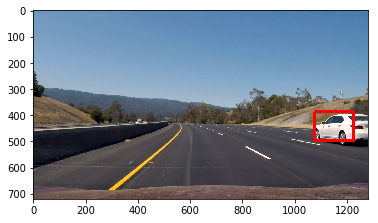

In [14]:
WINDOWS = [
    ((128, 128), (380, 560), (790, 1280)),
    ((128, 256), (380, 560), (790, 1280)),
    ((64, 128),  (380, 470), (790, 1280)),
    ((96, 192),  (380, 490), (790, 1280)),
    ((96, 128),  (380, 490), (790, 1280)),
    
    ((264, 264),  (350, 650), (850, 1280)),
    ((200, 330),  (370, 600), (850, 1280)),
    ((260, 300),  (370, 600), (950, 1280))
]
HEATMAP_THRESHOLD = 8
    
#path_to_images = glob(PATH_TO_TEST_IMAGES)

path_to_image = PATH_TO_PROJECT_IMAGE_INTPUT_PREFIX + '200.jpg'

image = cv2.imread(path_to_image)

start_time = time()

heatmap = create_aggregated_heat_map(
    p_image=image,
    p_feature_scaler=feature_scaler,
    p_classifier=classifier,
    p_blur=(71, 71),
    p_windows=WINDOWS,
    p_verbose=True)

draw_boxes(
    p_image=image, 
    p_heatmap=heatmap,
    p_threshold=HEATMAP_THRESHOLD,
    p_verbose=True)

print('Finish processing image in %.3f minutes' % ((time() - start_time) / 60.0))

In [87]:
#previous_heatmap = None

def process_video(
        p_path_to_input_video, 
        p_path_to_output_video,
        p_blur,
        p_hitmap_threshold,
        p_windows,
        p_sample,
        p_min_frame,
        p_max_frame):

    start_time = time()
    
    input_video = cv2.VideoCapture(p_path_to_input_video)
    output_video = None

    frame_num = -1
    while True:
        ret, frame = input_video.read()

        if p_sample > 0 and (frame_num % p_sample) != 0:
            continue
            
        if ret == False:
            break
        
        frame_num += 1
        
        if frame_num < p_min_frame:
            continue;
        if frame_num > p_max_frame:
            break;

        if output_video is None:
            output_video = cv2.VideoWriter(
                p_path_to_output_video, 
                cv2.VideoWriter_fourcc(*'mp4v'), 
                30, 
                (frame.shape[1], int(frame.shape[0] * 1.5)))

        heatmap = create_aggregated_heat_map(
            p_image=frame,
            p_blur=p_blur,
            p_feature_scaler=feature_scaler,
            p_classifier=classifier,
            p_windows=p_windows,
            p_verbose=False)

        #global previous_heatmap
        #if (previous_heatmap == None):
        #    previous_heatmap = heatmap
        #heatmap = previous_heatmap * 1/4 + heatmap * 3/4
        #previous_heatmap = heatmap
        
        lower_output_frame, thresholded_frame = draw_boxes(frame, heatmap, p_threshold=p_hitmap_threshold, p_verbose=False)
        
        #heatmap = ny.ndarray(plt.imshow(heatmap, cmap='hot'))
        heatmap = heatmap / heatmap.max()
        cmap = plt.get_cmap('hot')
        rgba_img = cmap(heatmap)
        rgb_img = np.delete(rgba_img, 3, 2)
        heatmap = cv2.resize(rgb_img[:, :, ::-1], (heatmap.shape[1] // 2, heatmap.shape[0] // 2))
        heatmap = heatmap * 255

        thresholded_frame = cv2.resize(
            thresholded_frame, (thresholded_frame.shape[1] // 2, thresholded_frame.shape[0] // 2)) * 255
        thresholded_frame = cv2.cvtColor(thresholded_frame, cv2.COLOR_GRAY2BGR)
        
        upper_output_frame = np.concatenate((heatmap, thresholded_frame), axis=1)
        
        output_frame = np.concatenate(
            (upper_output_frame, lower_output_frame),
            axis=0)

        cv2.putText(output_frame, 
                    'Frame %d' % frame_num,
                    (50, 450),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    2,
                    (0, 0, 255),
                    5)
        
        output_frame = output_frame.astype(np.uint8)

        output_video.write(output_frame)
        
        print('.', end='')

    input_video.release()
    output_video.release()
    cv2.destroyAllWindows()
    
    print()
    print('Finish processing video in %.2f minutes' % ((time() - start_time) / 60.0))

In [89]:
WINDOWS = [
    ((128, 128), (380, 560), (790, 1280)),
    ((128, 256), (380, 560), (790, 1280)),
    ((64, 128),  (380, 470), (790, 1280)),
    ((96, 192),  (380, 490), (790, 1280)),
    ((96, 128),  (380, 490), (790, 1280)),
    
    ((264, 264),  (350, 650), (850, 1280)),
    ((200, 330),  (370, 600), (850, 1280)),
    ((260, 300),  (370, 600), (950, 1280))
]
HEATMAP_THRESHOLD = 19

#global previous_heatmap
#previous_heatmap = None

process_video(
    p_path_to_input_video=PATH_TO_PROJECT_VIDEO_INTPUT, 
    p_path_to_output_video=PATH_TO_PROJECT_VIDEO_OUTPUT, #PREFIX_PATH + 'project_video_sample_out.mp4',
    p_blur=(71, 71),
    p_hitmap_threshold=HEATMAP_THRESHOLD,
    p_windows=WINDOWS,
    p_sample=0,
    p_min_frame=0,
    p_max_frame=1300)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [ ]:
"""
def save_video_to_image_files(p_input_video_file, p_image_directory):
    clip = VideoFileClip(p_input_video_file)
    for i, frame in enumerate(clip.iter_frames()):
        path_to_file = p_image_directory + str(i) + '.jpg'
        cv2.imwrite(path_to_file, frame[...,::-1])
        
save_video_to_image_files(PATH_TO_PROJECT_VIDEO_INTPUT, PATH_TO_PROJECT_IMAGE_INTPUT_PREFIX)
"""

In [ ]:
"""
HEATMAP_THRESHOLD = 10
IMAGE_WINDOW_SIZES = [(330, 200), (264, 264), (256, 128), (192, 96), (128, 256), (128, 128),
                      (96, 192), (96, 128), (96, 64), (64, 96), (64, 128), (48, 96)]

global previous_heatmap
previous_heatmap = None

process_video(
    p_path_to_input_video=PATH_TO_TEST_VIDEO_INTPUT, 
    p_path_to_output_video=PATH_TO_TEST_VIDEO_OUTPUT,
    p_row_span=(400, 690),
    p_col_span=(700, 1280),
    p_blur=(3, 3),
    p_hitmap_threshold=HEATMAP_THRESHOLD,
    p_image_window_sizes=IMAGE_WINDOW_SIZES,
    p_sample=0)
"""